# SCP Toolbox Workshop

___A tutorial on generating dynamically feasible trajectories reliably and efficiently___

Monday, February 7, 2022

Rocky Mountain AAS GN&C Conference, Breckenridge, CO

In [3215]:
import Pkg
Pkg.activate("..")

# these lines are required only for local installations
Pkg.develop(path="../../scp_traj_opt/")
Pkg.precompile()

using SCPToolbox
using PyPlot, Colors, LinearAlgebra

# Import the different possible low-level convex solvers
using COSMO
using Ipopt
using SCS
using ECOS
using OSQP

  Activating project at `~/Nextcloud/personal/research/scp/aas_gnc_workshop/tutorial`
   Resolving package versions...
  No Changes to `~/Nextcloud/personal/research/scp/aas_gnc_workshop/tutorial/Project.toml`
  No Changes to `~/Nextcloud/personal/research/scp/aas_gnc_workshop/tutorial/Manifest.toml`


# Part 4: Rocket-Landing Guidance

In this part of the tutorial, you will participate in formulating and solving a Lunar rocket landing trajectory optimization problem.

The rocket has a 2-dimensional position and a rotation, and a gimbaled rocket engine. The goal is to take the rocket from an airborne state to a soft touchdown on the ground.

<center>
    <img src="media/p4-rocket-landing-overview.png"
         alt="Dubin's car overview"
         style="background-color: white; width: 300px; display: block; margin-left: auto; margin-right: auto;"/>
    <br />
    <b>Figure.</b> Illustration of the rocket soft landing problem.
    <br />
    <br />
</center>

Begin by defining a new `TrajectoryProblem` object.

In [ ]:
pbm = # Enter your code here

<details>

<summary>Answer</summary>



```julia
pbm = TrajectoryProblem();
```
</details>

## Rocket dynamics

In general, the dynamics of any nonlinear system are given by:

$$
\dot x(t) = f( t, x(t), u(t), p )
$$

* $t\in \mathbb R$: time;
* $x(t)\in \mathbb R^n$: state vector;
* $u(t)\in \mathbb R^m$: input vector (the things that we can decide on);
* $p(t)\in \mathbb R^d$: "parameter" vector (problem specific);

In [3217]:
n, m, d = 7, 2, 1
problem_set_dims!(pbm, n, m, d)

## Rocket parameters

In [3218]:
# Environment parameters
g = 1.625 # [m/s^2] Gravitational acceleration of the planet
g_E = 9.807; # [m/s^2] Earth gravity

In [3219]:
# Mechanical parameters
m_wet = 25e3
L = 5.0 # Thrust lever arm
J = 100e3; # [kg*m^2] Moment of inertia

In [3220]:
# Propulsion parameters
Isp = 370 # [s] Specific impulse
T_min = 20e3 # [N] Minimum thrust
T_max = 80e3 # [N] Maximum thrust
α = 1 / (Isp * g_E)
δ_max = deg2rad(5.0);

In [3221]:
# Trajectory parameters
γ_gs = deg2rad(45.0); # [rad] Glideslope angle (measured from the horizon)

In [3222]:
f(t, x, u, p) = begin
    rx, ry, vx, vy, θ, ω, m = x
    T, δ = u
    tf, = p
    return [vx; vy; -(T/m)*sin(θ+δ); (T/m)*cos(θ+δ)-g; ω; -(L*T/J)*sin(δ); -α*T]*tf
end;

SCP algorithms work by iteratively linearizing nonconvex elements of the problem. This means that we have to provide the algorithm with the Jacobians of $f$.

\begin{align}
A(t, x, u, p) &= \nabla_x f(t, x, u, p), \\
B(t, x, u, p) &= \nabla_u f(t, x, u, p), \\
F(t, x, u, p) &= \nabla_p f(t, x, u, p).
\end{align}

In [3223]:
A(t, x, u, p) = begin
    rx, ry, vx, vy, θ, ω, m = x
    T, δ = u
    tf, = p
    return [0 0 1 0       0       0       0
            0 0 0 1       0       0       0
            0 0 0 0 -T/m*cos(θ+δ) 0 T/m^2*sin(θ+δ)
            0 0 0 0 -T/m*sin(θ+δ) 0 -T/m^2*cos(θ+δ)
            0 0 0 0       0       1       0
            0 0 0 0       0       0       0
            0 0 0 0       0       0       0]*tf
end

B(t, x, u, p) = begin
    rx, ry, vx, vy, θ, ω, m = x
    T, δ = u
    tf, = p
    return [     0            0
                 0            0
            -sin(θ+δ)/m -T/m*cos(θ+δ)
             cos(θ+δ)/m -T/m*sin(θ+δ)
                 0            0
            -L/J*sin(δ) -L*T/J*cos(δ)
                -α            0       ]*tf
end

F(t, x, u, p) = begin
    rx, ry, vx, vy, θ, ω, m = x
    T, δ = u
    tf, = p
    return reshape(f(t, x, u, p)/tf, 7, 1)
end;

In [3224]:
wrap(func) = (t, k, x, u, p, pbm) -> func(t, x, u, p)
problem_set_dynamics!(pbm, wrap(f), wrap(A), wrap(B), wrap(F))

## Boundary Conditions

The initial and terminal boundary conditions on the trajectory are set by the following two constraints:

\begin{align}
g_{ic}(x(0), p) &= 0, \\
g_{tc}(x(1), p) &= 0.
\end{align}

In [3225]:
km2m(x) = x*1e3 # Conversion from km to m
kph2mps(v) = v/3.6 # Conversion from km/h to m/s

x_0 = [km2m(0.5); km2m(1.4); kph2mps(80); kph2mps(-100); deg2rad(-30.0); deg2rad(0.0); m_wet]
x_f = zeros(6)

g_ic(x, p) = x-x_0
g_tc(x, p) = x[1:6]-x_f;

Again, we need to provide the Jacobians of $g_{ic}$ and $g_{tc}$, since in general these may be nonaffine functions.

\begin{align}
H_0(x(0), p) &= \nabla_x g_{ic}(x(0), p), \\
K_0(x(0), p) &= \nabla_p g_{ic}(x(0), p), \\
H_f(x(1), p) &= \nabla_x g_{tc}(x(1), p), \\
K_f(x(1), p) &= \nabla_p g_{tc}(x(1), p).
\end{align}

When a Jacobian is not provided, the SCP Toolbox assumes that it is zero.

In [3226]:
H_0(x, p) = I(7)
H_f(x, p) = collect(hcat(I(6), zeros(6)));

In [3227]:
wrap(func) = (x, p, pbm) -> func(x, p)
problem_set_bc!(pbm, :ic, wrap(g_ic), wrap(H_0))
problem_set_bc!(pbm, :tc, wrap(g_tc), wrap(H_f))

## State constraints

In [3228]:
tf_min = 40.0 # [s] Minimum time of flight
nonnegative_time_of_flight(tf, clp) = @add_constraint(clp, NONPOS, tf -> tf_min-tf);

In [3229]:
glide_slope(x, clp) = @add_constraint(clp, L1, x -> begin
        x, y = x[1], x[2]
        return [y/tan(γ_gs); x]
    end);

In [3230]:
problem_set_X!(pbm, (t, k, x, p, pbm, clp) -> begin
        tf = p[1]
        nonnegative_time_of_flight(tf, clp)
        glide_slope(x, clp)
    end)

## Control constraints

In [3231]:
thrust_upper_bound(T, clp) = @add_constraint(clp, NONPOS, T -> T-T_max)
thrust_lower_bound(T, clp) = @add_constraint(clp, NONPOS, T -> T_min-T)
gimbal_limit(δ, clp) = @add_constraint(clp, L1, δ -> vcat(δ_max, δ));

In [3232]:
problem_set_U!(pbm, (t, k, u, p, pbm, clp) -> begin
        T, δ = u[1], u[2]
        thrust_upper_bound(T, clp)
        thrust_lower_bound(T, clp)
        gimbal_limit(δ, clp)
    end)

## Objective Function

1000.0Borrowing from the standard choice in optimal control literature, the SCP Toolbox works with an objective function in the Bolza form:

$$
J(x, u, p) = \phi(x(1), p) + \int_0^1 \Gamma(x(t), u(t), p) dt.
$$

The function $\phi(\cdot)\in\mathbb R$ defines the terminal cost, while $\Gamma(\cdot)\in\mathbb R$ defines the running cost. Both have to be convex, at most quadratic, functions.

> ℹ️ Any nonconvexity in the cost can in general be off-loaded into the constraints by defining additional state, control, and/or parameter variables.

In [3233]:
ϕ(x, p) = -x[end]/m_wet;

The SCP Toolbox provides the following API functions for defining the cost:
* `problem_set_terminal_cost!`: if not provided, it is assumed that $\phi\equiv 0$;
* `problem_set_running_cost!`: if not provided, it is assumed that $\Gamma\equiv 0$;

In [3234]:
wrap(func) = (x, p, pbm) -> func(x, p)
problem_set_terminal_cost!(pbm, wrap(ϕ))

In [3235]:
# Γ(x, u, p) = ( u[1]/T_max )^2
# wrap(func) = (t, k, x, u, p, pbm) -> func(x, u, p)
# problem_set_running_cost!(pbm, :ptr, wrap(Γ))

## Initial Trajectory Guess

SCP algorithms require an initial guess for the trajectory. This can be very simple, and does not need to be feasible.

For Dubin's car, we will use a straight line for the state and zero for the input.

Given a time $t\in [0,1]$, the state initial guess will be:

\begin{align}
\bar x(t) &= (1-t) x_0 + t x_f, \\
\bar u(t) &= 0.
\end{align}

SCP algorithms work by discretizing the trajectory problem into $N$ temporal nodes.

The API provides a function `problem_set_guess!` for defining the initial guess, discretized into $N$ points.

For convenience, a function `straightline_interpolate` is available to define a straight line guess.

In [3236]:
T_guess = T_min+0.5*(T_max-T_min) # [N] Initial thrust guess
v_0, v_f = x_0[3:4], x_f[3:4]
tf_guess = norm(v_f-v_0, 2)/(T_guess/m_wet-g)
Δm_guess = -α*T_guess*tf_guess
m_dry_guess = x_0[end]+Δm_guess

state_guess(N) = straightline_interpolate(x_0, vcat(x_f, m_dry_guess), N)
input_guess(N) = straightline_interpolate([T_guess; 0.0], [T_guess; 0.0], N);

In [3237]:
problem_set_guess!(pbm, (N, pbm) -> begin
    x = state_guess(N)
    u = input_guess(N)
    p = [tf_guess]
    return x, u, p
end)

## Variable Scaling

Variable scaling is important when the solution variables are of widely different magnitudes.

The SCP Toolbox performs automatic scaling for variables whose magnitudes are naturally constrained by the convex constraints.

However, you can also set the variable scaling manually by providing the expected value ranges for each variable.

This is done using the SCP Toolbox API function `problem_advise_scale!!`.

In [3238]:
rx_range_box = max(x_0[1], 1.0)
ry_range_box = max(x_0[2], 1.0)
vx_range_box = max(abs(x_0[3]), 1.0)
vy_range_box = min(x_0[4], -1.0)
θ_range_box = deg2rad(20.0)
ω_range_box = max(abs(x_0[6]), deg2rad(5.0))
m_range_box = m_wet

problem_advise_scale!(pbm, :state, 1, (-rx_range_box, rx_range_box))
problem_advise_scale!(pbm, :state, 2, (0, ry_range_box))
problem_advise_scale!(pbm, :state, 3, (-vx_range_box, vx_range_box))
problem_advise_scale!(pbm, :state, 4, (vy_range_box, 0.0))
problem_advise_scale!(pbm, :state, 5, (-θ_range_box, θ_range_box))
problem_advise_scale!(pbm, :state, 6, (-ω_range_box, ω_range_box))
problem_advise_scale!(pbm, :state, 7, (m_wet+Δm_guess, m_wet))

δ_range_box = deg2rad(1.0)

problem_advise_scale!(pbm, :input, 1, (T_min, T_max))
problem_advise_scale!(pbm, :input, 2, (-δ_range_box, δ_range_box))

problem_advise_scale!(pbm, :parameter, 1, (0.1*tf_guess, tf_guess))

## Configuring the SCP Solver

The SCP Toolbox provides several SCP algorithm choices: `PTR`, `SCvx`, and `GuSTO`.

Each algorithm must be provided with a set of parameters that define its behavior. Most of the parameters are shared, but some are algorithm-specific.

SCP algorithm performance depends significantly on a well-chosen set of parameters, and this is problem-dependent.

A lot of intuition is documented in our [Control Systems Magazine article](https://arxiv.org/abs/2106.09125).

In [3239]:
# Parameters
N, Nsub = 20, 20
iter_max = 30
disc_method = FOH
wvc, wtr = 1e1, 1e-1
feas_tol = 5e-3
ε_abs, ε_rel = 1e-5, 1e-4
q_tr = Inf
q_exit = Inf
solver, solver_options = ECOS, Dict("verbose"=>0)      

pars = PTR.Parameters(N, Nsub, iter_max, disc_method, wvc, wtr, ε_abs,
                      ε_rel, feas_tol, q_tr, q_exit, solver, solver_options);

Alternative convex solver options:

In [3240]:
# solver, options = Gurobi, Dict("OutputFlag"=>0)  # works
# solver, options = OSQP, Dict("verbose"=>0)       # works
# solver, options = Mosek, Dict("MSK_IPAR_LOG"=>0)
# solver, options = Ipopt, Dict()                  # doesn't work
# solver, options = COSMO, Dict()                  # doesn't work
# solver, options = SCS, Dict()                    # doesn't work

## Solving the Trajectory Problem

Solving the problem amounts to initializing the SCP solver with its parameters, and providing the problem definition `pbm` from the API.

In [3241]:
ptr_pbm = PTR.create(pars, pbm)
sol, history = PTR.solve(ptr_pbm);

k  | status   | vd    | vs    | vbc   | J         | ΔJ %      | Δx    | Δu    | Δp    | δ     | dyn | ηx    | ηu    | ηp   
---+----------+-------+-------+-------+-----------+-----------+-------+-------+-------+-------+-----+-------+-------+------
1  | OPTIMAL  | 1e-10 | 0e+00 | 2e-13 | -8.73e-01 |           | 2e+00 | 2e+00 | 1e-01 | 2e+00 | F   | 2.18  | 1.57  | 0.12 
2  | OPTIMAL  | 2e-11 | 0e+00 | 5e-14 | -9.06e-01 | 3.79      | 8e-01 | 1e+00 | 7e-12 | 8e-01 | F   | 0.77  | 1.00  | 0.00 
3  | OPTIMAL  | 1e-09 | 0e+00 | 3e-13 | -9.42e-01 | 4.01      | 5e-02 | 6e-01 | 4e-11 | 5e-02 | F   | 0.05  | 0.64  | 0.00 
4  | OPTIMAL  | 9e-11 | 0e+00 | 8e-14 | -9.49e-01 | 0.75      | 9e-03 | 5e-02 | 2e-11 | 9e-03 | T   | 0.01  | 0.05  | 0.00 
5  | OPTIMAL  | 1e-09 | 0e+00 | 7e-13 | -9.50e-01 | 0.13      | 1e-03 | 1e-03 | 2e-11 | 1e-03 | T   | 0.00  | 0.00  | 0.00 
6  | OPTIMAL  | 9e-09 | 0e+00 | 2e-11 | -9.50e-01 | 0.00      | 2e-07 | 2e-06 | 1e-08 | 2e-07 | T   | 0.00  | 0.00  | 0.00 


## Trajectory plot

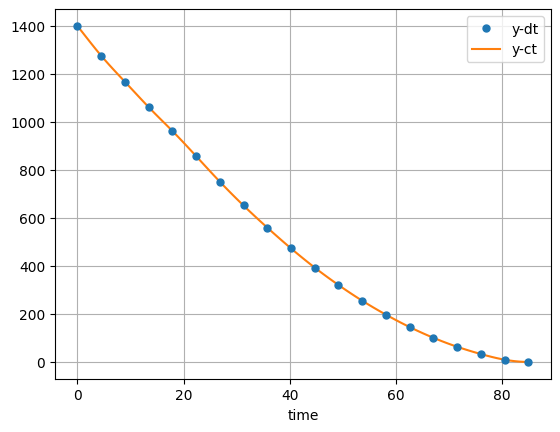

In [3242]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.grid()

_sol = history.subproblems[end].sol

tf = _sol.p[1]
xd = _sol.xd
ud = _sol.ud
vd = _sol.vd
p_sol = _sol.p
td = sol.td*tf

Nc = 100
tc = LinRange(0, tf, Nc)
xc = hcat([sample(sol.xc, t) for t in LinRange(0, 1, Nc)]...)

# ax.plot(td, xd[1, :], marker=".", linestyle="none", label="x")

# ax.plot(td, xd[2, :], marker=".", markersize=10, linestyle="none", label="y-dt", zorder=100)
# ax.plot(td, xd[2, :], linestyle="-", label="y-ct")

ax.plot(td, xd[2, :], marker=".", markersize=10, linestyle="none", label="y-dt", zorder=100)
ax.plot(tc, xc[2, :], linestyle="-", label="y-ct")

ax.legend()

ax.set_xlabel("time")
;

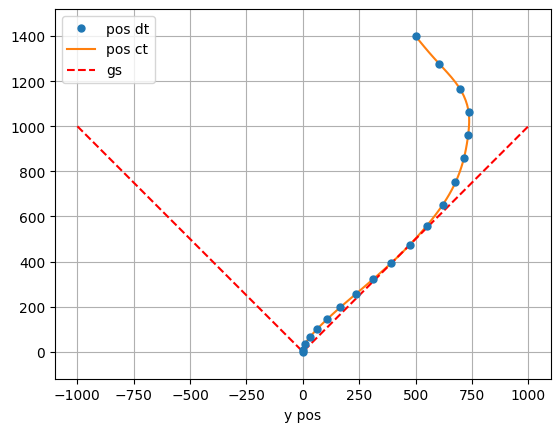

In [3243]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.grid()
ax.axis("equal")

ax.plot(xd[1, :], xd[2, :], marker=".", markersize=10, linestyle="none", label="pos dt", zorder=100)
ax.plot(xc[1, :], xc[2, :], linestyle="-", label="pos ct")

span_gs = max(100, 2*abs(x_0[1]))
x_cone = [-span_gs; 0; span_gs]
ax.plot(x_cone, tan(γ_gs).*abs.(x_cone), linestyle="--", color="red", label="gs")

ax.legend()

ax.set_xlabel("x pos")
ax.set_xlabel("y pos")
;

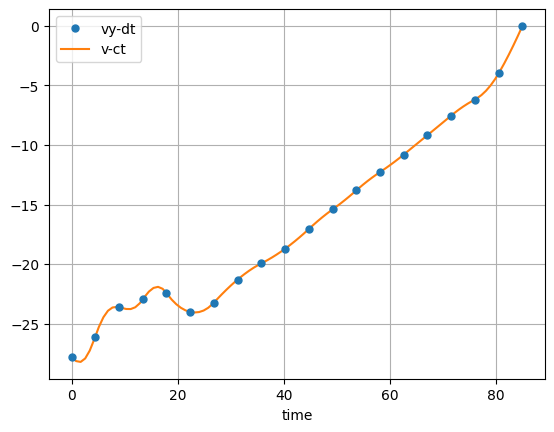

In [3244]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.grid()

ax.plot(td, xd[4, :], marker=".", markersize=10, linestyle="none", label="vy-dt", zorder=100)
ax.plot(tc, xc[4, :], linestyle="-", label="v-ct")

ax.legend()

ax.set_xlabel("time")
;

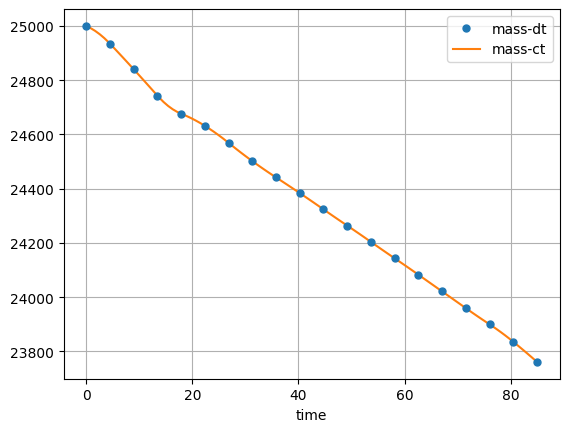

In [3245]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.grid()

ax.plot(td, xd[7, :], marker=".", markersize=10, linestyle="none", label="mass-dt", zorder=100)
ax.plot(tc, xc[7, :], linestyle="-", label="mass-ct")

ax.legend()

ax.set_xlabel("time")
;

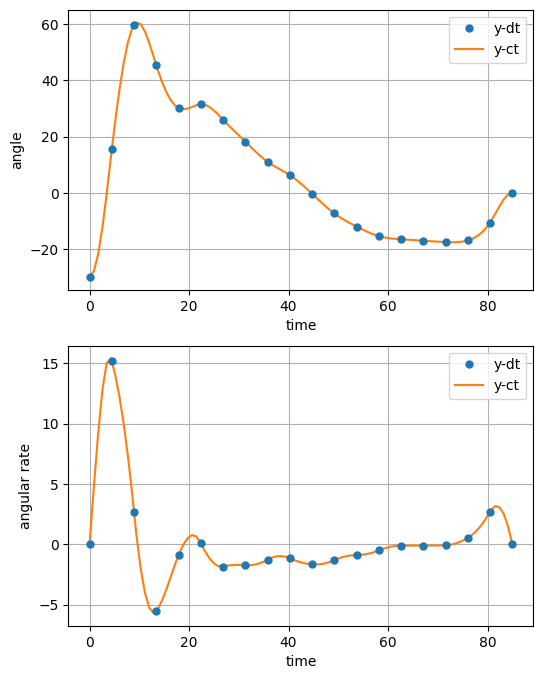

In [3246]:
fig = plt.figure(figsize=(6, 8))
ax = fig.add_subplot(211)

ax.grid()

ax.plot(td, rad2deg.(xd[5, :]), marker=".", markersize=10, linestyle="none", label="y-dt", zorder=100)
ax.plot(tc, rad2deg.(xc[5, :]), linestyle="-", label="y-ct")

ax.legend()

ax.set_xlabel("time")
ax.set_ylabel("angle")

ax = fig.add_subplot(212)

ax.grid()

ax.plot(td, rad2deg.(xd[6, :]), marker=".", markersize=10, linestyle="none", label="y-dt", zorder=100)
ax.plot(tc, rad2deg.(xc[6, :]), linestyle="-", label="y-ct")

ax.legend()

ax.set_xlabel("time")
ax.set_ylabel("angular rate")
;

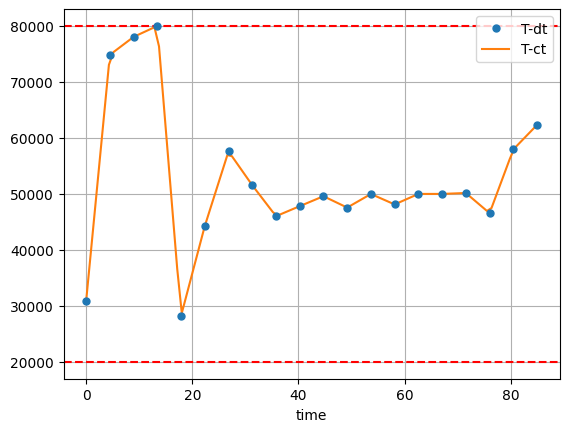

PyObject Text(0.5, 24.0, 'time')

In [3247]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.grid()

uc = hcat([sample(sol.uc, t) for t in LinRange(0, 1, Nc)]...)

ax.plot(td, ud[1, :], marker=".", markersize=10, linestyle="none", label="T-dt", zorder=100)
ax.plot(tc, uc[1, :], linestyle="-", label="T-ct")

ax.axhline(y=T_min, color="red", linestyle="--")
ax.axhline(y=T_max, color="red", linestyle="--")

ax.legend()
tc
ax.set_xlabel("time")

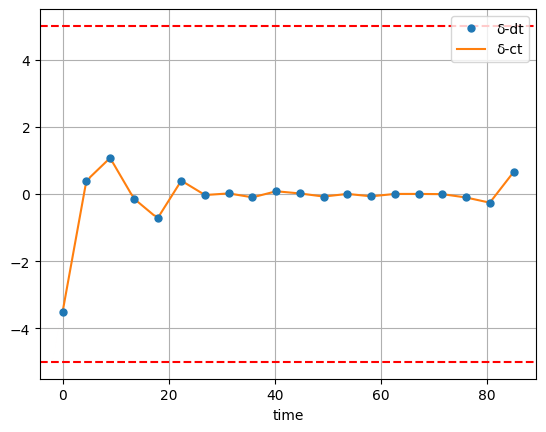

PyObject Text(0.5, 24.0, 'time')

In [3248]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.grid()

ax.plot(td, rad2deg.(ud[2, :]), marker=".", markersize=10, linestyle="none", label="δ-dt", zorder=100)
ax.plot(tc, rad2deg.(uc[2, :]), linestyle="-", label="δ-ct")

ax.axhline(y=rad2deg(-δ_max), color="red", linestyle="--")
ax.axhline(y=rad2deg(δ_max), color="red", linestyle="--")

ax.legend()
tc
ax.set_xlabel("time")

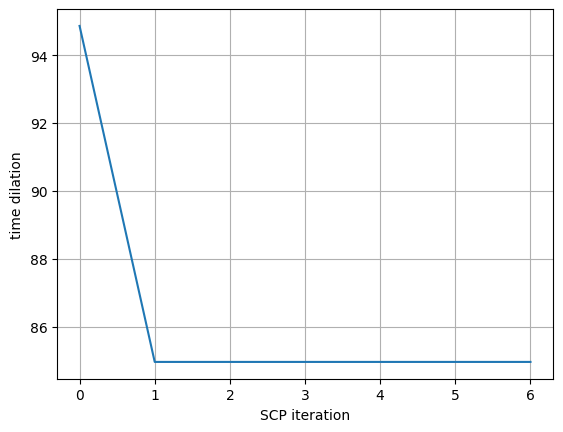

In [3249]:
tf_values = [spbm.sol.p[1] for spbm in history.subproblems]
pushfirst!(tf_values, history.subproblems[1].ref.p[1])

fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.grid()
ax.plot(tf_values)
ax.set_xlabel("SCP iteration")
ax.set_ylabel("time dilation")
;

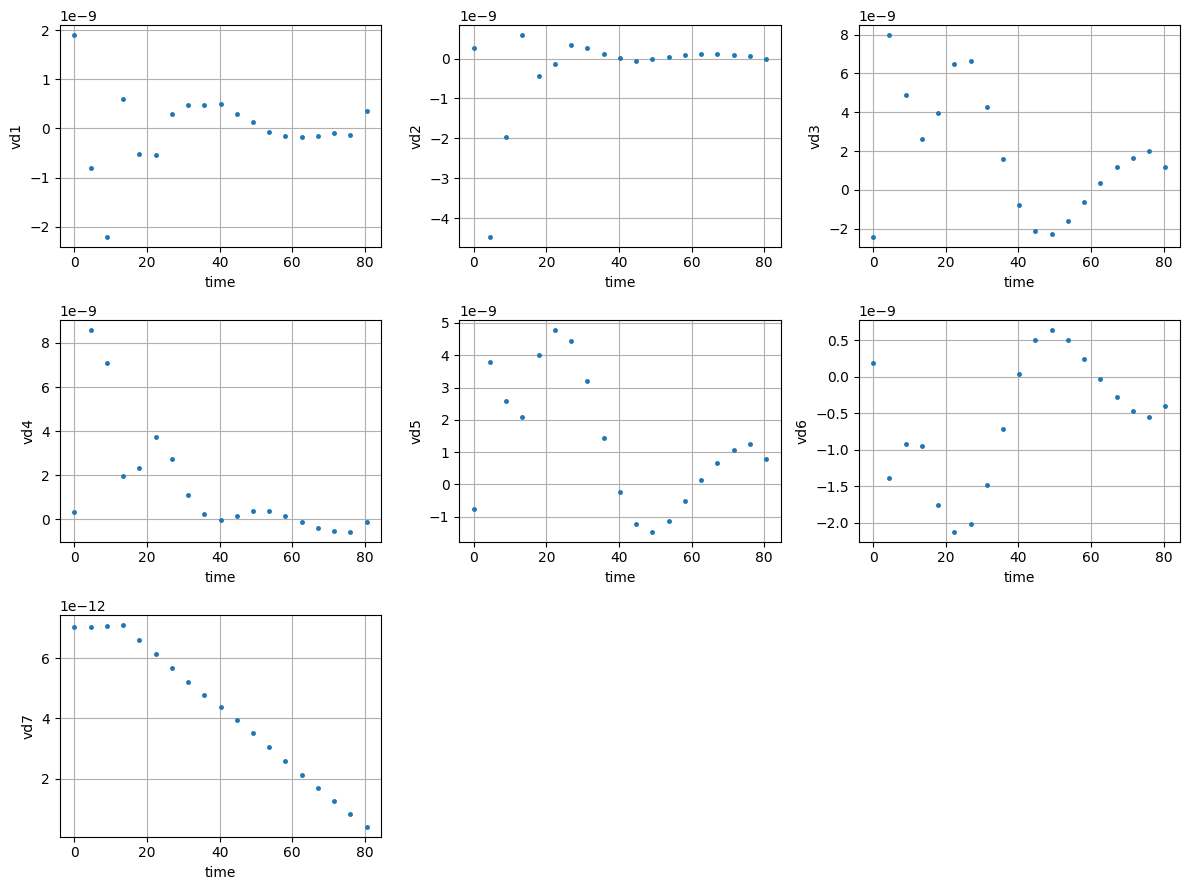

In [3250]:
fig = plt.figure(figsize=(12, 9))
for i = 1:7
    ax = fig.add_subplot(3, 3, i)
    ax.grid()
    ax.plot(td[1:end-1], vd[i, :], marker=".", markersize=5, linestyle="none", label="T-dt", zorder=100)
    ax.set_ylabel("vd$i")
    ax.set_xlabel("time")
end
plt.tight_layout()

In [3251]:
# function set_fonts()::Nothing
#     # Set the figure fonts.
#     fig_small_sz = 12
#     fig_med_sz = 15
#     fig_big_sz = 17
#     plt.rc("text", usetex=true)
#     plt.rc("font", size=fig_small_sz, family="serif")
#     plt.rc("axes", titlesize=fig_small_sz)
#     plt.rc("axes", labelsize=fig_med_sz)
#     plt.rc("xtick", labelsize=fig_small_sz)
#     plt.rc("ytick", labelsize=fig_small_sz)
#     plt.rc("legend", fontsize=fig_small_sz)
#     plt.rc("figure", titlesize=fig_big_sz)
#     plt.rc("figure", dpi=300) 
#     return nothing
# end
# ;

In [3252]:
# # Trajectory plot
# ctres, overlap = 1000, 3
# N = size(sol.xd, 2)
# xct = hcat([sample(sol.xc, t) for t in LinRange(0, 1, ctres)]...)
# vct = vcat([sample(sol.uc, t)[1] for t in LinRange(0, 1, ctres)]...)
# cmap = generate_colormap("inferno"; minval=minimum(vct), maxval=maximum(vct))

# # plot_options = Dict("xtick.labelsize"=>9,
# #                     "ytick.labelsize"=>9,
# #                     "axes.labelsize"=>11)
# # fig = create_figure((4, 4); options = plot_options)

# fig = plt.figure(figsize=(4,4), dpi=300)
# plt.clf()
# set_fonts()
# set_fonts()

# ax = setup_axis!(111, xlabel="\$x\$ [m]", ylabel="\$y\$ [m]",
#                  axis="equal", cbar=cmap, clabel="Velocity, \$v\$ [m/s]",
#                  cbar_aspect=40)
# ax.plot(sol.xd[1, :], sol.xd[2, :],
#         linestyle="none", marker="o", markerfacecolor=DarkBlue,
#         markeredgecolor="white", markeredgewidth=0.2, markersize=3,
#         zorder=20)
# line_segs = Vector{Matrix}(undef, 0)
# line_clrs = Vector{NTuple{4, Real}}(undef, 0)
# for k=1:ctres-overlap
#     push!(line_segs, xct[1:2, k:k+overlap]')
#     push!(line_clrs, cmap.to_rgba(vct[k]))
# end
# trajectory = PyPlot.matplotlib.collections.LineCollection(
#     line_segs, zorder=10, colors = line_clrs, linewidths=3,
#     capstyle="round")
# ax.add_collection(trajectory)
# Rect = PyPlot.matplotlib.patches.Rectangle
# car_length = 0.2
# for k=1:N
#     local xl, xw = [1;1;-1;-1;1]*car_length/2, [1;-1;-1;1;1]*car_width/2
#     local yl, yw = [1;1;-1;-1;1]*car_length/2, [-1;1;1;-1;-1]*car_width/2
#     local ang = sol.xd[3,k]
#     local xc = sol.xd[1,k].+xl.*sin(ang).+xw.*cos(ang)
#     local yc = sol.xd[2,k].+yl.*cos(ang).+yw.*sin(ang)
#     ax.fill(xc, yc,
#             linewidth=1,
#             edgecolor=DarkBlue,
#             facecolor=rgb2pyplot(parse(RGB, Red), a=0.5),
#             zorder=6)
# end
# ang = LinRange(0, 2*pi, 100)
# obs = ([cos.(ang)'; sin.(ang)']*r_0).+c_0
# ax.fill(obs[1, :], obs[2, :],
#         linewidth=1,
#         edgecolor=Blue,
#         facecolor=rgb2pyplot(parse(RGB, Green), a=0.5),
#         zorder=5)

# fig.savefig("../media/outputs/dubin_trajectory.png", dpi="figure", bbox_inches=nothing)

# plt.close()

## Replace figure

<!-- <div style="text-align: center">
    <img src="../media/outputs/dubin_trajectory.png"
         alt="Dubin's car overview"
         style="background-color: white; width: 500px; display: block; margin-left: auto; margin-right: auto;"/>
    <br />
    <b>Figure.</b> Computed Dubin's car trajectory for minimum-input usage.
</div> -->